<a href="https://colab.research.google.com/github/JianfengMI/MLprojects/blob/main/Sentiment_Analysis_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
#import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input,GlobalMaxPooling1D,Embedding,TextVectorization,LayerNormalization,MultiHeadAttention)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [ ]:
BATCH_SIZE=64

# Data Preparation

In [ ]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.MQ9T9R_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.MQ9T9R_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.MQ9T9R_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for review,label in val_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [ ]:
def standardization(input_data):
    '''
    Input: raw reviews (string or tf.Tensor)
    Output: standardized reviews, lower case, HTML tags removed, punctuation removed, whitespace normalized
    '''
    if isinstance(input_data, tf.Tensor):
        # Convert to lowercase
        text = tf.strings.lower(input_data)
        # Remove HTML tags
        text = tf.strings.regex_replace(text, "<[^>]+>", "")
        # Remove punctuation
        text = tf.strings.regex_replace(text, "[%s]"%re.escape(string.punctuation), "")
        # Normalize whitespace
        text = tf.strings.regex_replace(text, r'\s+', ' ')
        text = tf.strings.strip(text)
        return text
    else:
        # Handle Python strings
        text = input_data.lower()
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

In [ ]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [ ]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [ ]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [ ]:
# lengths=[]
# words=[]

# for review,label in train_ds.take(100):
#   # for word in tf.strings.split(review, sep=" "):
#   #   if word in words:
#   #     pass
#   #   else:
#   #     words.append(word)
#   lengths.append(len(tf.strings.split(review, sep=" ")))

In [ ]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data

In [ ]:
len(training_data), train_ds.element_spec

(25000,
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)))

In [ ]:
len(vectorize_layer.get_vocabulary())

10000

In [ ]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [ ]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [ ]:
len(train_dataset), train_dataset.element_spec

(25000,
 (TensorSpec(shape=(250,), dtype=tf.int64, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)))

In [ ]:
for i in range(20):
  print(vectorize_layer.get_vocabulary()[i])


[UNK]
the
and
a
of
to
is
in
it
this
i
that
was
as
with
for
movie
but
film


In [ ]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [ ]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

# Modeling

## Transformers

### Embeddings

In [ ]:
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [ ]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
      config = super().get_config()
      config.update({
        "sequence_length": self.sequence_length,
        "vocab_size": self.vocab_size,
        "embed_dim": self.embed_dim,
      })
      return config


In [ ]:
test_input=tf.constant([[  2, 112,   10,   12,  5,   0,   0,   0,]])

emb=Embeddings(8,20000,256)
emb_out=emb(test_input)
print(emb_out.shape)

(1, 8, 256)


### Encoder

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )
        self.dense_proj=tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"),Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
      if mask is not None:
        mask1 = mask[:, :, tf.newaxis]
        mask2 = mask[:,tf.newaxis, :]
        padding_mask = tf.cast(mask1&mask2, dtype="int32")

      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,attention_mask=padding_mask
      )

      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
      config = super().get_config()
      config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
      })
      return config

In [ ]:
encoder_outputs = TransformerEncoder(256,2048,2)(emb_out)
print(encoder_outputs.shape)


(1, 8, 256)


### Transformer Model

In [ ]:
# import GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D

In [ ]:
# Define constants
SEQUENCE_LENGTH = 250  # Maximum length of input sequences
VOCAB_SIZE = 10000     # Size of the vocabulary (e.g., for tokenization)
EMBEDDING_DIM = 256    # Embedding dimension
D_FF = 512             # Feed-forward network dimension
NUM_HEADS = 8          # Number of attention heads
NUM_LAYERS = 2         # Number of Transformer encoder layers
DROPOUT_RATE = 0.1     # Dropout rate

# Custom TransformerEncoder layer
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, d_ff, num_heads, dropout_rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.d_ff = d_ff
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        # Multi-Head Attention
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Feed-forward network
        self.ffn = tf.keras.Sequential([
            Dense(d_ff, activation="relu"),
            Dense(embed_dim)
        ])
        # Layer normalization
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # Dropout
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # Multi-Head Attention
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Add & Norm

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Add & Norm

# Build the model
encoder_input = Input(shape=(None,), dtype="int64", name="input")
x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=SEQUENCE_LENGTH)(encoder_input)

# Stack TransformerEncoder layers
for _ in range(NUM_LAYERS):
    x = TransformerEncoder(embed_dim=EMBEDDING_DIM, d_ff=D_FF, num_heads=NUM_HEADS, dropout_rate=DROPOUT_RATE)(x)

# Aggregate sequence output (use GlobalAveragePooling1D instead of Flatten)
x = GlobalAveragePooling1D()(x)

# Output layer for binary classification
output = Dense(1, activation="sigmoid")(x)

# Create the model
transformer = Model(inputs=encoder_input, outputs=output, name="transformer")

# Display model summary
transformer.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, None, 256)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, None, 256)      │     2,367,488 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_4           │ (None, None, 256)      │     2,367,488 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,295,233 (27.83 MB)

 Trainable params: 7,295,233 (27.83 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
checkpoint_filepath = 'transformer.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 135s 305ms/step - accuracy: 0.6995 - loss: 0.5494 - val_accuracy: 0.8707 - val_loss: 0.3054
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 117s 269ms/step - accuracy: 0.8946 - loss: 0.2588 - val_accuracy: 0.8595 - val_loss: 0.3513
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 268ms/step - accuracy: 0.9172 - loss: 0.2091 - val_accuracy: 0.8469 - val_loss: 0.4260
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 269ms/step - accuracy: 0.9306 - loss: 0.1777 - val_accuracy: 0.8406 - val_loss: 0.5295
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 104s 267ms/step - accuracy: 0.9457 - loss: 0.1433 - val_accuracy: 0.8402 - val_loss: 0.5504
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 149s 284ms/step - accuracy: 0.9500 - loss: 0.1270 - val_accuracy: 0.8294 - val_loss: 0.6220
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 105s 268ms/step - accuracy: 0.9559 - loss: 0.1154 - val_accuracy: 0.8349 - val_loss: 0.6187
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 111s 283ms/step - accuracy: 0.9515 -

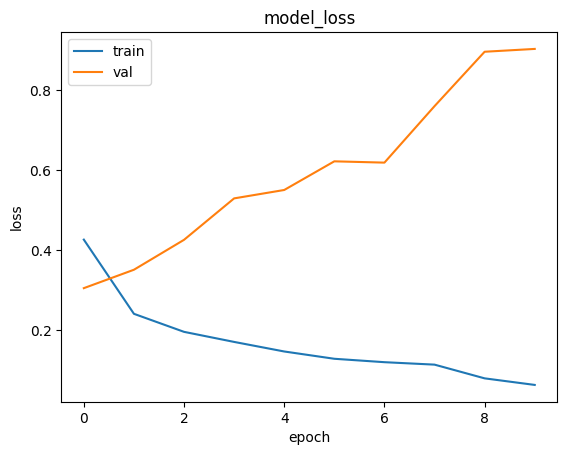

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

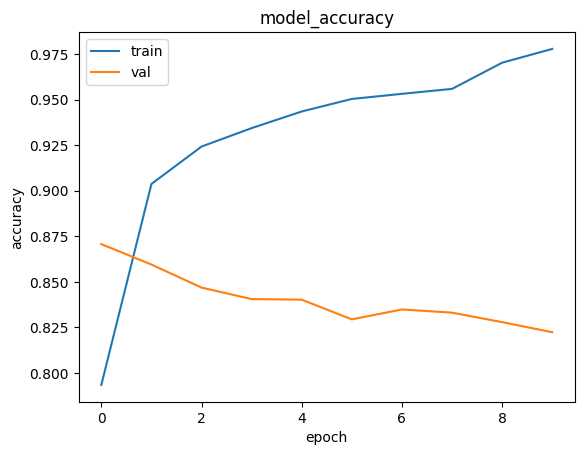

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
transformer.load_weights(checkpoint_filepath)

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
transformer.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.8683 - loss: 0.3091


[0.31090447306632996, 0.8687199950218201]

# Testing

In [ ]:
# test_pos="this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "
# test_neg="very good start, but movie started becoming boring at some point and unfortunately i didn't feel like this was properly produced as there was too much background noise, and the actors didn't look motivated at all "

In [ ]:
test_data=tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, so in all i didn't like this movie "],])


In [ ]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [ ]:
transformer.predict(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


array([[0.93111205],
       [0.12031243]], dtype=float32)

# LSH Attention

In [ ]:
# Define constants
SEQUENCE_LENGTH = 250  # Maximum length of input sequences
VOCAB_SIZE = 10000     # Vocabulary size
EMBEDDING_DIM = 256    # Embedding dimension
D_FF = 512             # Feed-forward network dimension
NUM_HEADS = 8          # Number of attention heads
NUM_LAYERS = 2         # Number of Transformer encoder layers
DROPOUT_RATE = 0.1     # Dropout rate
NUM_HASHES = 4         # Number of LSH hashes
BUCKET_SIZE = 64       # Bucket size for LSH

# Custom LSHAttention layer
class LSHAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, num_hashes=4, bucket_size=64, dropout_rate=0.1, **kwargs):
        super(LSHAttention, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_hashes = num_hashes
        self.bucket_size = bucket_size
        self.dropout_rate = dropout_rate
        self.head_dim = embed_dim // num_heads

        # Linear projections for query, key, value
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.dropout = Dropout(dropout_rate)

    def call(self, query, key, value, training=False):
        batch_size = tf.shape(query)[0]
        seq_length = tf.shape(query)[1]

        # Linear projections
        query = self.query_dense(query)  # (batch_size, seq_length, embed_dim)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Reshape for multi-head attention
        query = tf.reshape(query, (batch_size, seq_length, self.num_heads, self.head_dim))
        key = tf.reshape(key, (batch_size, seq_length, self.num_heads, self.head_dim))
        value = tf.reshape(value, (batch_size, seq_length, self.num_heads, self.head_dim))
        query = tf.transpose(query, [0, 2, 1, 3])  # (batch_size, num_heads, seq_length, head_dim)
        key = tf.transpose(key, [0, 2, 1, 3])
        value = tf.transpose(value, [0, 2, 1, 3])

        # LSH: Random projections for hashing
        random_vectors = tf.random.normal((self.num_heads, self.num_hashes, self.head_dim, self.bucket_size // 2))
        random_vectors = tf.tile(random_vectors[None, :, :, :, :], [batch_size, 1, 1, 1, 1])  # (batch_size, num_heads, num_hashes, head_dim, bucket_size//2)

        # Compute hashes for query and key
        query_hashes = tf.einsum('bhld,bhnlk->bhln', query, random_vectors)  # (batch_size, num_heads, seq_length, num_hashes)
        key_hashes = tf.einsum('bhld,bhnlk->bhln', key, random_vectors)

        # Assign to buckets
        query_buckets = tf.argmax(query_hashes, axis=-1)  # (batch_size, num_heads, seq_length)
        key_buckets = tf.argmax(key_hashes, axis=-1)      # (batch_size, num_heads, seq_length)

        # Mask for same-bucket attention
        mask = tf.cast(tf.equal(query_buckets[:, :, :, None], key_buckets[:, :, None, :]), tf.float32)  # (batch_size, num_heads, seq_length, seq_length)

        # Scaled dot-product attention
        scores = tf.matmul(query, key, transpose_b=True) / tf.sqrt(tf.cast(self.head_dim, tf.float32))  # (batch_size, num_heads, seq_length, seq_length)
        scores = scores * mask + (1.0 - mask) * tf.float32.min  # Apply mask
        attention_weights = tf.nn.softmax(scores, axis=-1)
        attention_weights = self.dropout(attention_weights, training=training)

        # Apply attention to values
        attention_output = tf.matmul(attention_weights, value)  # (batch_size, num_heads, seq_length, head_dim)
        attention_output = tf.transpose(attention_output, [0, 2, 1, 3])  # (batch_size, seq_length, num_heads, head_dim)
        attention_output = tf.reshape(attention_output, (batch_size, seq_length, self.embed_dim))

        return attention_output

    def compute_output_shape(self, input_shape):
        return input_shape  # (batch_size, seq_length, embed_dim)

In [ ]:
# Custom TransformerEncoder layer with LSHAttention
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, d_ff, num_heads, num_hashes=4, bucket_size=64, dropout_rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.d_ff = d_ff
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        # LSH Attention
        self.attention = LSHAttention(embed_dim, num_heads, num_hashes, bucket_size, dropout_rate)
        # Feed-forward network
        self.ffn = tf.keras.Sequential([
            Dense(d_ff, activation="relu"),
            Dense(embed_dim)
        ])
        # Layer normalization
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # Dropout
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # LSH Attention
        attn_output = self.attention(inputs, inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Add & Norm

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Add & Norm

    def compute_output_shape(self, input_shape):
        return input_shape  # (batch_size, seq_length, embed_dim)

In [ ]:
# Build the model
encoder_input = Input(shape=(None,), dtype="int64", name="input")
x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=SEQUENCE_LENGTH)(encoder_input)

# Stack TransformerEncoder layers with LSHAttention
for _ in range(NUM_LAYERS):
    x = TransformerEncoder(
        embed_dim=EMBEDDING_DIM,
        d_ff=D_FF,
        num_heads=NUM_HEADS,
        num_hashes=NUM_HASHES,
        bucket_size=BUCKET_SIZE,
        dropout_rate=DROPOUT_RATE
    )(x)

# Aggregate sequence output
x = GlobalAveragePooling1D()(x)

# Output layer for binary classification
output = Dense(1, activation="sigmoid")(x)

In [ ]:
# Create the model
transformer = Model(inputs=encoder_input, outputs=output, name="transformer")

# Display model summary
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, None, 256)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, None, 256)      │       461,312 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, None, 256)      │       461,312 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,482,881 (13.29 MB)

 Trainable params: 3,482,881 (13.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# training LSH model
checkpoint_filepath = 'transformer_lsh.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10


ValueError: Exception encountered when calling LSHAttention.call().

[1mDimensions must be equal, but are 250 and 32 for '{{node transformer_1/transformer_encoder_2_1/lsh_attention_2_1/einsum/Einsum}} = Einsum[N=2, T=DT_FLOAT, equation="bhld,bhnlk->bhln"](transformer_1/transformer_encoder_2_1/lsh_attention_2_1/transpose, transformer_1/transformer_encoder_2_1/lsh_attention_2_1/Tile)' with input shapes: [?,8,250,32], [?,8,4,32,32].[0m

Arguments received by LSHAttention.call():
  • query=tf.Tensor(shape=(None, 250, 256), dtype=float32)
  • key=tf.Tensor(shape=(None, 250, 256), dtype=float32)
  • value=tf.Tensor(shape=(None, 250, 256), dtype=float32)
  • training=True

## LSH Attention

In [ ]:
EMBEDDING_DIM=128
D_FF=1024
NUM_HEADS=8
NUM_LAYERS=1
NUM_EPOCHS=20

In [ ]:
def look_one_back(x):
  x_extra=tf.concat([x[:,-1:,...],x[:,:-1,...]],axis=1)
  return tf.concat([x,x_extra],axis=2)

def sticker_look_one_back(x):
  x_extra=tf.concat([x[:-1:],x[:,:-1]],axis=1)
  return tf.concat([x,x_extra],axis=-1)

def causal_masker(a,b):
  a,b=tf.cast(a,dtype=tf.float32)+0.01,tf.cast(b,dtype=tf.float32)+0.01
  vals=tf.einsum('ipj,ipk->ipjk',b,1/a)
  out=tf.cast(tf.cast(tf.cast(vals,dtype=tf.int32),dtype=tf.bool),dtype=tf.int32)
  out=-out+1
  return tf.cast(out,dtype=tf.float32)

class LSHAttention(tf.keras.layers.Layer):
    def __init__(self,bucket_size=8,n_hashes=1):
        super(LSHAttention,self).__init__()
        self.n_hashes=n_hashes
        self.bucket_size=bucket_size

    def call(self,query,key,value,causal_masking=False):
        R=tf.random.normal((tf.shape(query)[0],tf.shape(query)[-1],self.bucket_size//2))
        xR=tf.matmul(query,R)
        concat_xR=tf.concat([xR,-xR],axis=-1)
        buckets=tf.math.argmax(concat_xR,axis=-1)

        sticker=tf.argsort(buckets)
        undo_sort=tf.argsort(sticker)
        sorted_query=tf.gather(query,sticker,axis=1,batch_dims=1)
        sorted_value=tf.gather(value,sticker,axis=1,batch_dims=1)

        chunked_query=tf.stack(tf.split(sorted_query,self.bucket_size,1),1)
        chunked_value=tf.stack(tf.split(sorted_value,self.bucket_size,1),1)

        sticker=tf.stack(tf.split(sticker,self.bucket_size,1),1)
        new_sticker=sticker_look_one_back(sticker)

        lb_chunked_query=look_one_back(chunked_query)
        lb_chunked_value=look_one_back(chunked_value)

        score=tf.einsum('bhie,bhje->bhij',chunked_query,lb_chunked_query)
        score/=tf.math.sqrt(tf.cast(query.shape[-1],tf.float32))

        if causal_masking==True:
            causal_mask=causal_masker(sticker,new_sticker)
            dots+=causal_mask*-1e-10
        score=tf.nn.softmax(score)
        output=tf.einsum('buij,buje->buie',score,lb_chunked_value)

        sorted_output=tf.reshape(output,(tf.shape(output)[0],tf.shape(query)[i],output.shape[3]))
        output=tf.gather(sorted_output,undo_sort,axis=1,batch_dims=1)
        return output

In [ ]:
# Custom TransformerEncoder layer with LSHAttention
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, d_ff, num_heads, num_hashes=4, bucket_size=64, dropout_rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.d_ff = d_ff
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        # LSH Attention
        self.attention = LSHAttention(embed_dim, num_heads, num_hashes, bucket_size, dropout_rate)
        # Feed-forward network
        self.ffn = tf.keras.Sequential([
            Dense(d_ff, activation="relu"),
            Dense(embed_dim)
        ])
        # Layer normalization
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # Dropout
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # LSH Attention
        attn_output = self.attention(inputs, inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Add & Norm

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Add & Norm

    def compute_output_shape(self, input_shape):
        return input_shape  # (batch_size, seq_length, embed_dim)

In [ ]:
# Build the model
encoder_input = Input(shape=(None,), dtype="int64", name="input")
x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=SEQUENCE_LENGTH)(encoder_input)

# Stack TransformerEncoder layers with LSHAttention
for _ in range(NUM_LAYERS):
    x = TransformerEncoder(
        embed_dim=EMBEDDING_DIM,
        d_ff=D_FF,
        num_heads=NUM_HEADS,
        num_hashes=NUM_HASHES,
        bucket_size=BUCKET_SIZE,
        dropout_rate=DROPOUT_RATE
    )(x)

# Aggregate sequence output
x = GlobalAveragePooling1D()(x)

# Output layer for binary classification
output = Dense(1, activation="sigmoid")(x)

# Create the model
transformer = Model(inputs=encoder_input, outputs=output, name="transformer")

# Display model summary
transformer.summary()

TypeError: LSHAttention.__init__() takes from 1 to 3 positional arguments but 6 were given